## 8. EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)



El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguiente fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} *test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







#### Importar lo necesario

In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from numpy.ma.core import log10

#### configuramos el `device` acorde al device disponible




In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class ImageDataset(Dataset):
    def __init__(self, labels, images, transform=None, target_transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label =  self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
        

1. Cargar base de datos

In [4]:
import pickle

train_feature = pickle.load( open( "/content/train.pkl", "rb" ) )
train_label = pickle.load( open( "/content/train_label.pkl", "rb" ) )
val_feature = pickle.load( open( "/content/val.pkl", "rb" ) )
val_label = pickle.load( open( "/content/val_label.pkl", "rb" ) )
test_feature = pickle.load( open( "/content/test.pkl", "rb" ) )
test_label = pickle.load( open( "/content/test_label.pkl", "rb" ) )

train_dataset = ImageDataset(train_label,train_feature, transform=transforms.Compose([transforms.ToTensor()]))
val_dataset = ImageDataset(val_label,val_feature, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = ImageDataset(test_label,test_feature, transform=transforms.Compose([transforms.ToTensor()]))

dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=False, pin_memory=False),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, pin_memory=False),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False, pin_memory=False),
}

2. Ver que la base de datos esté OK

In [5]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Feature batch shape: torch.Size([2, 1, 28, 28])
Labels batch shape: torch.Size([2])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


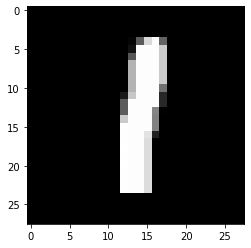

Label: 1


In [6]:
# Display image and label from dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = train_features[0].squeeze()
print('tamaño 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

3. Construyo mi CNN

In [7]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 4)
    self.conv1_out = None
    self.conv2 = block(4, 4)
    self.conv2_out = None
    self.conv3 = block(4, 8)
    self.conv3_out = None
    self.conv4 = block(8, 8)
    self.conv4_out = None
    self.conv5 = block(8, 16)
    self.conv5_out = None
    self.conv6 = block(16, 16)
    self.conv6_out = None
    self.fc = torch.nn.Linear(16*2*2, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)

    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)
    
    #self.score = i / log10(pytorch_total_params)
    #print('Score: ', self.score)

  def validar_dim(self):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)

    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)

    x = self.conv6(x)
    print("Tamaño salida conv6: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    self.conv6_out = self.conv6(self.conv5_out)
    y = self.conv6_out.view(self.conv6_out.shape[0], -1)
    y = self.fc(y)
    y = self.sm(y)
    return y

In [8]:
model = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, di

In [9]:
model.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 16
Tamaño entrada:  torch.Size([1, 1, 16, 16])
Tamaño salida conv1:  torch.Size([1, 4, 9, 9])
Tamaño salida conv2:  torch.Size([1, 4, 5, 5])
Tamaño salida conv3:  torch.Size([1, 8, 3, 3])
Tamaño salida conv4:  torch.Size([1, 8, 2, 2])
Tamaño salida conv5:  torch.Size([1, 16, 2, 2])
Tamaño salida conv6:  torch.Size([1, 16, 2, 2])
Tamaño imagen vectorizada:  torch.Size([1, 64])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


In [10]:
from tqdm import tqdm # <- para graficar la barra de avance


def fit(model, dataloader, epochs=1):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            #print('y_hat',y_hat)
            #print('y',y)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        bar = tqdm(dataloader['val'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} train_loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} train_acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


In [23]:
def score(model, dataloader):
    bar = tqdm(dataloader['test'])
    test_loss, test_acc = [], []
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            test_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            test_acc.append(acc)
            bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_acc {np.mean(test_acc):.5f}")
    
    i=0
    for layer in model.children():
        i=i+1
    
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    test_acc = np.mean(test_acc)
    print(test_acc)
    score = i / log10(pytorch_total_params) * test_acc
    
    print('Test Accuracy =',test_acc)
    print('Numero total de parametros =',pytorch_total_params)
    print('Cantidad de layer =',i)
    print('El Socre final es de =', score)

In [12]:
fit(model, dataloader)

val_loss 1.55332 val_acc 0.90800: 100%|██████████| 3500/3500 [00:19<00:00, 177.93it/s]


Epoch 1/1 loss 1.67328 val_loss 1.55332 acc 0.78620 val_acc 0.90800


# score final

In [24]:
score(model, dataloader)

test_loss 1.55332 test_acc 0.90800: 100%|██████████| 3500/3500 [00:19<00:00, 175.88it/s]

0.908
Test Accuracy = 0.908
Numero total de parametros = 5206
Cantidad de layer = 8
El Socre final es de = 1.954524919090943
